In [69]:
from sklearn.datasets import load_iris
import pandas as pd
import numpy as np
import math
import operator
import matplotlib.pyplot as plt

In [2]:
iris_data= load_iris()
full_data = pd.DataFrame(iris_data.data, columns = iris_data.feature_names)

full_data["sepal_length_category"] = np.where(full_data['sepal length (cm)'] < 5, "0", "1")
full_data["sepal_length_category"] = np.where(full_data['sepal length (cm)'] >= 6 , "2", full_data['sepal_length_category'])

full_data["petal_length_category"] = np.where(full_data['petal length (cm)'] < 2, "0", "1")
full_data["petal_length_category"] = np.where(full_data['petal length (cm)'] >= 5 , "2", full_data['petal_length_category'])

full_data.drop(columns = ["sepal length (cm)", "petal length (cm)"], inplace = True)
full_data["Iris"] = iris_data.target

# Decision Tree using ID3

In [3]:
#https://www.youtube.com/watch?v=OD8aO4ovIBo&t=81s

Calculate the entropy for a given attribute $A$'s class:

$$Entropy(c_1, c_2, ..., c_n) = - \frac{c_1}{c_1 + c_2 + ... + c_n}\log_n(\frac{c_1}{c_1 + c_2 + ... + c_n}) - \frac{c_2}{c_1 + c_2 + ... + c_n}\log_n(\frac{c_2}{c_1 + c_2 + ... + c_n}) - ... - \frac{c_n}{c_1 + c_2 + ... + c_n}\log_n(\frac{c_n}{c_1 + c_2 + ... + c_n})$$  

where $c_i$ is the number of instances of class $i$ of the target variable




Then, calculate the expected information of attribute $A$, $E(A)$:

$$E(A) = \sum\limits_{i=1}^v[ \frac{c_{1,i} + c_{2,i} + ... + c_{n,i}}{c_1 + c_2 + ... + c_n}Entropy(c_{1,i}, c_{2,i}, ..., c_{n,i})]$$

where $i$ is the class of attribute $A$ and $c_{j,i}$ is the number of instances of the target class $j$ within $i$

Information gained by branching on attribute $A$:  
     
$$gain(A) = Entropy(C_1, C_2, ..., C_n) - E(A)$$  

where the entropy above is the entropy of the target variable over the whole dataset

In [4]:
def get_entropy(target_data_sub, target_classes):
    entropy = 0
    n = len(target_data_sub)
    for target_class in target_classes:
        target_class_count = len(target_data_sub[target_data_sub == target_class])
        if target_class_count > 0:
            entropy += - (target_class_count / n) * math.log(target_class_count / n, len(target_classes))
    return entropy

In [5]:
def get_cutoffs(attribute):
    """
    for continuous variables, sort all values in ascending order an get the mean value between each adjacent point,
    or cutoffs. Return the list of unique cutoff values 
    """
    
    cutoffs = np.array([])
    attribute_copy = attribute.sort_values().reset_index(drop=True).copy()
    for i in range(len(attribute_copy) - 1):
        cutoffs = np.append(cutoffs, (attribute_copy[i + 1] + attribute_copy[i]) / 2)
    return np.unique(cutoffs)

In [27]:
def get_expected_information(attribute_name, data, continuous = False):
    """
    Args:
        - attribute_name: name of attribute whose expected information we ar getting
        - data: data used for the given tree node (i.e., if root node, data = full_data)
        - continuous: boolean value to check if the variable is categorical or continuous
        
    Returns: expected information for the given attribtue
    """
    
    target_classes = set(full_data["Iris"])
    attribute_data = data[attribute_name].copy()
    exp_info = 0
    n_observations = len(attribute_data)
    
    if continuous:
        
        cutoffs = get_cutoffs(attribute_data)
        min_exp_info = float("inf")
        min_cf = 0
        
        for cf in cutoffs:
            
            target_data_left = data.loc[data[attribute_name] <= cf, "Iris"]
            left_entropy = get_entropy(target_data_left, target_classes)
            n_left = target_data_left.shape[0]
            
            target_data_right = data.loc[data[attribute_name] > cf, "Iris"]
            right_entropy = get_entropy(target_data_right, target_classes)
            n_right = target_data_right.shape[0]
            
            exp_info = (n_left / n_observations) * left_entropy + (n_right / n_observations) * right_entropy
            
            if exp_info < min_exp_info:
                min_exp_info = exp_info
                min_cf = cf
                
        return [min_exp_info, min_cf]
    
    else:
        
        for attr_class in set(attribute_data):
            
            n_attr_class = data[data[attribute_data.name] == attr_class].shape[0]
            target_data = data.loc[data[attribute_name] == attr_class, "Iris"]
            exp_info += (n_attr_class / n_observations) * get_entropy(target_data, target_classes)
            
        return [exp_info, None]

In [7]:
# get entropy of target class
def get_target_entropy(target_data):
    """
    Args:
        - target_data: pd series with data from target variable
    """
    target_entropy = 0
    n = target_data.shape[0]
    for target_class in set(target_data):
        target_class_count = target_data[target_data == target_class].shape[0]
        target_entropy -= (target_class_count / n) * math.log(target_class_count / n, len(set(target_data)))
    return target_entropy

In [8]:
target_entropy = get_target_entropy(full_data["Iris"])

In [45]:
print(f"sepal width (cm) information gain: {target_entropy - get_expected_information('sepal width (cm)', full_data, True)[0]}, cutoff: {get_expected_information('sepal width (cm)', full_data, True)[1]}")
print(f"petal width (cm) information gain: {target_entropy - get_expected_information('petal width (cm)', full_data, True)[0]}, cutoff: {get_expected_information('petal width (cm)', full_data, True)[1]}")

print('sepal_length_category information gain: ',target_entropy - 
      get_expected_information('sepal_length_category', full_data)[0] )
print('petal_length_category information gain: ',target_entropy - 
      get_expected_information('petal_length_category', full_data)[0] )

sepal width (cm) information gain: 0.17863261057596602, cutoff: 3.3
petal width (cm) information gain: 0.579380164285695, cutoff: 0.8
sepal_length_category information gain:  0.3367224570251872
petal_length_category information gain:  0.8357697892170907


In [55]:
def is_continuous(data):
    return True if type(data[0]) != str else False

In [56]:
def branch_on(data):
    """
    get variable with highest information gain to branch on
    """
    gains = dict()
    target_entropy = get_target_entropy(data["Iris"])
    for column in set(data.columns).difference(set(["Iris"])):
        continuous = is_continuous(data[column])
        gains[column] = target_entropy - get_expected_information(column, data, continuous)[0]
    return max(gains.items(), key=operator.itemgetter(1))[0]

In [57]:
branch_on(full_data)

'petal_length_category'

In [66]:
class Node:
    
    def __init__(self, variable_name, edges, parent, continuous = False):
        self.variable_name = variable_name
        self.edges = edges
        self.parent = parent
        self.continuous = continuous
        self.children = []
        
    
    def get_children(self):
        return self.children
    
    def get_parent(self):
        return self.parent
    
    def add_child(self, node):
        self.children.append(node)
        
    def is_root(self):
        return True if not self.parent else False

class Edge:
    
    def __init__(self, value):
        self.value = value
    
    def get_value(self):
        return self.value
    
    
class DecisionTree:
    
    def __init__(self, root):
        self.root = root
        
      

In [67]:
root = Node("petal_length_category", [Edge(value) for value in set(full_data["petal_length_category"])], None)

In [68]:
root.is_root()

True

In [12]:
from sklearn import tree



dt = tree.DecisionTreeClassifier(criterion = "entropy")
dt.fit(full_data[['petal width (cm)', 'petal width (cm)', 'sepal_length_category', 'petal_length_category']], full_data["Iris"])

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

[Text(167.4, 199.32, 'X[0] <= 0.8\nentropy = 1.585\nsamples = 150\nvalue = [50, 50, 50]'),
 Text(145.08, 163.07999999999998, 'entropy = 0.0\nsamples = 50\nvalue = [50, 0, 0]'),
 Text(189.72, 163.07999999999998, 'X[1] <= 1.75\nentropy = 1.0\nsamples = 100\nvalue = [0, 50, 50]'),
 Text(89.28, 126.83999999999999, 'X[3] <= 1.5\nentropy = 0.445\nsamples = 54\nvalue = [0, 49, 5]'),
 Text(44.64, 90.6, 'X[1] <= 1.65\nentropy = 0.146\nsamples = 48\nvalue = [0, 47, 1]'),
 Text(22.32, 54.359999999999985, 'entropy = 0.0\nsamples = 47\nvalue = [0, 47, 0]'),
 Text(66.96000000000001, 54.359999999999985, 'entropy = 0.0\nsamples = 1\nvalue = [0, 0, 1]'),
 Text(133.92000000000002, 90.6, 'X[1] <= 1.55\nentropy = 0.918\nsamples = 6\nvalue = [0, 2, 4]'),
 Text(111.6, 54.359999999999985, 'entropy = 0.0\nsamples = 3\nvalue = [0, 0, 3]'),
 Text(156.24, 54.359999999999985, 'X[0] <= 1.65\nentropy = 0.918\nsamples = 3\nvalue = [0, 2, 1]'),
 Text(133.92000000000002, 18.119999999999976, 'entropy = 1.0\nsamples = 2

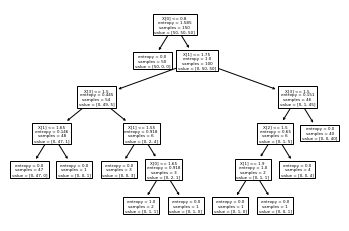

In [23]:
tree.plot_tree(dt)

In [22]:
root = Node([Edge(value) for value in set(full_data["petal_length_category"])], None)
decision_tree = DecisionTree(root)

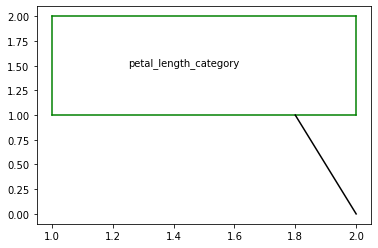

In [87]:

plt.plot([1,1], [2,1], color="green")
plt.plot([2,1], [2,2], color="green")
plt.plot([1,2], [1,1], color="green")
plt.plot([2,2], [1,2], color="green")
plt.text(1.25, 1.5, "petal_length_category")
plt.plot([1.8, 2], [1, 0], color="black")